# Exploring Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus project

## ⚠️ AI-Generated Notebook Warning

**This notebook was generated by an AI system and has not been fully verified. Please be cautious when interpreting the code, results, and analyses presented here. Always validate findings with additional sources or your own analysis.**

## Overview

This notebook explores Dandiset 000690, "Allen Institute Openscope - Vision2Hippocampus project", which investigates how visual information is processed from thalamus through visual cortex to the hippocampus in mice. The dataset contains recordings of neural activity using Neuropixel probes while mice were presented with various visual stimuli.

You can access the full Dandiset at: https://dandiarchive.org/dandiset/000690

In this notebook, we will:
1. Connect to the DANDI archive and retrieve the Dandiset metadata
2. List available assets (NWB files) in the dataset
3. Load an example NWB file and examine its contents
4. Explore neural recordings (LFP data) 
5. Visualize eye tracking data during stimulus presentation
6. Analyze and visualize relationships between visual stimuli and neural activity
7. Explore mouse running behavior in relation to visual stimuli

## Required Packages

First, let's import the necessary packages for accessing and analyzing the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import h5py
import remfile

# DANDI-specific packages
from dandi.dandiapi import DandiAPIClient

# NWB file handling
import pynwb

# Set up plot styling
sns.set_theme()

## Connecting to DANDI and Accessing the Dandiset

In [2]:
# Connect to the DANDI archive
client = DandiAPIClient()

# Access the specific Dandiset
dandiset = client.get_dandiset("000690")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata['description'][:500]}...")  # First 500 chars for brevity

Dandiset name: Allen Institute Openscope - Vision2Hippocampus project
Dandiset URL: https://dandiarchive.org/dandiset/000690/0.250326.0015
Description: Extensive research shows that visual cortical neurons respond to specific stimuli, e.g. the primary visual cortical neurons respond to bars of light with specific orientation. In contrast, the hippocampal neurons are thought to encode not specific stimuli but instead represent abstract concepts such as space, time and events. How is this abstraction computed in the mouse brain? Specifically, how does the representation of simple visual stimuli evolve from the thalamus, which is a synapse away fr...


### Listing Assets in the Dandiset

In [3]:
# List the assets in the Dandiset
assets = list(dandiset.get_assets())
print(f"\nFound {len(assets)} assets in the dataset")

# Group assets by type for a better overview
asset_paths = [asset.path for asset in assets]
asset_types = {}

for path in asset_paths:
    if '_ecephys.nwb' in path:
        key = 'ecephys'
    elif '_image.nwb' in path:
        key = 'image'
    elif '.nwb' in path and not ('_ecephys' in path or '_image' in path):
        key = 'session'
    else:
        key = 'other'
    
    if key not in asset_types:
        asset_types[key] = []
    asset_types[key].append(path)

# Print summary of asset types
for asset_type, paths in asset_types.items():
    print(f"\n{asset_type.upper()} files: {len(paths)}")
    for path in paths[:3]:  # Show just a few examples
        print(f"- {path}")
    if len(paths) > 3:
        print(f"  ...and {len(paths) - 3} more")


Found 156 assets in the dataset

ECEPHYS files: 106
- sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb
- sub-692077/sub-692077_ses-1300222049_probe-3_ecephys.nwb
- sub-692077/sub-692077_ses-1300222049_probe-2_ecephys.nwb
  ...and 103 more

SESSION files: 25
- sub-692077/sub-692077_ses-1300222049.nwb
- sub-695435/sub-695435_ses-1309235849.nwb
- sub-715811/sub-715811_ses-1328842209.nwb
  ...and 22 more

IMAGE files: 25
- sub-695762/sub-695762_ses-1317448357_image.nwb
- sub-692072/sub-692072_ses-1298465622_image.nwb
- sub-695435/sub-695435_ses-1309235849_image.nwb
  ...and 22 more


## Loading and Exploring an NWB File

Let's load one of the image NWB files to explore the visual stimuli and associated data.

In [4]:
# We'll load the image file for subject 692072
image_file_url = "https://api.dandiarchive.org/api/assets/cbc64387-19b9-494a-a8fa-04d3207f7ffb/download/"
print(f"Loading NWB file from URL: {image_file_url}")

# Load the file using remfile and h5py to stream it without downloading
remote_file = remfile.File(image_file_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb_image = io.read()

# Display basic info about the file
print(f"\nFile identifier: {nwb_image.identifier}")
print(f"Session description: {nwb_image.session_description}")
print(f"Session start time: {nwb_image.session_start_time}")
print(f"Subject: {nwb_image.subject.subject_id}, {nwb_image.subject.age}, {nwb_image.subject.sex}")

Loading NWB file from URL: https://api.dandiarchive.org/api/assets/cbc64387-19b9-494a-a8fa-04d3207f7ffb/download/



File identifier: 1298465622
Session description: Data and metadata for an Ecephys session
Session start time: 2023-09-21 00:00:00-07:00
Subject: 692072, P82D, M


### Exploring Visual Stimulus Information

This dataset contains various visual stimuli presented to the mice. Let's examine the available stimulus templates.

In [5]:
# List the available stimulus templates
print("Available stimulus templates:")
for i, (name, _) in enumerate(nwb_image.stimulus_template.items()):
    print(f"{i+1}. {name}")

# Let's look at the details of the first few stimulus intervals
print("\nStimulus presentation intervals (first 3):")
interval_keys = list(nwb_image.intervals.keys())[:3]
for key in interval_keys:
    # Get the first few rows as a dataframe
    df = nwb_image.intervals[key].to_dataframe().head(2)
    print(f"\n{key}:")
    print(f"  Total presentations: {len(nwb_image.intervals[key].to_dataframe())}")
    print(f"  Sample presentations:\n")
    print(df[['start_time', 'stop_time', 'stimulus_name', 'stimulus_index']].to_string(index=False))

Available stimulus templates:
1. Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
2. Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
3. GreenSAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
4. Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
5. SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
6. SAC_Wd15_Vel2_Bndry1_Cntst1_loop_presentations
7. SAC_Wd15_Vel2_Bndry2_Cntst0_loop_presentations
8. SAC_Wd15_Vel2_Bndry2_Cntst0_oneway_presentations
9. SAC_Wd15_Vel2_Bndry3_Cntst0_loop_presentations
10. SAC_Wd15_Vel8_Bndry1_Cntst0_loop_presentations
11. SAC_Wd45_Vel2_Bndry1_Cntst0_loop_presentations
12. UD_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
13. acurl_Wd15_Vel2_Bndry1_Cntst0_oneway_presentations
14. curl_Wd15_Vel2_Bndry1_Cntst0_oneway_presentations
15. natmovie_CricketsOnARock_540x960Full_584x460Active_presentations
16. natmovie_EagleSwooping1_540x960Full_584x460Active_presentations
17. natmovie_EagleSwooping2_540x960Full_584x460Active_presentations
18. natmovie_SnakeOnARoad_540x960Full_5


Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations:


  Total presentations: 57600
  Sample presentations:

 start_time  stop_time                          stimulus_name  stimulus_index
  4514.8164 4514.83306 Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop            13.0
  4514.8164 4514.83306 Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop            13.0



Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations:


  Total presentations: 28800
  Sample presentations:

 start_time  stop_time                     stimulus_name  stimulus_index
 3794.21309 3794.22976 Disk_Wd15_Vel2_Bndry1_Cntst0_loop             9.0
 3794.21309 3794.22976 Disk_Wd15_Vel2_Bndry1_Cntst0_loop             9.0



GreenSAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations:


  Total presentations: 28800
  Sample presentations:

 start_time  stop_time                         stimulus_name  stimulus_index
 4274.61528 4274.63198 GreenSAC_Wd15_Vel2_Bndry1_Cntst0_loop            12.0
 4274.61528 4274.63198 GreenSAC_Wd15_Vel2_Bndry1_Cntst0_loop            12.0


### Examining Eye Tracking Data

The dataset includes eye tracking data recorded during stimulus presentation. Let's visualize some of this data.

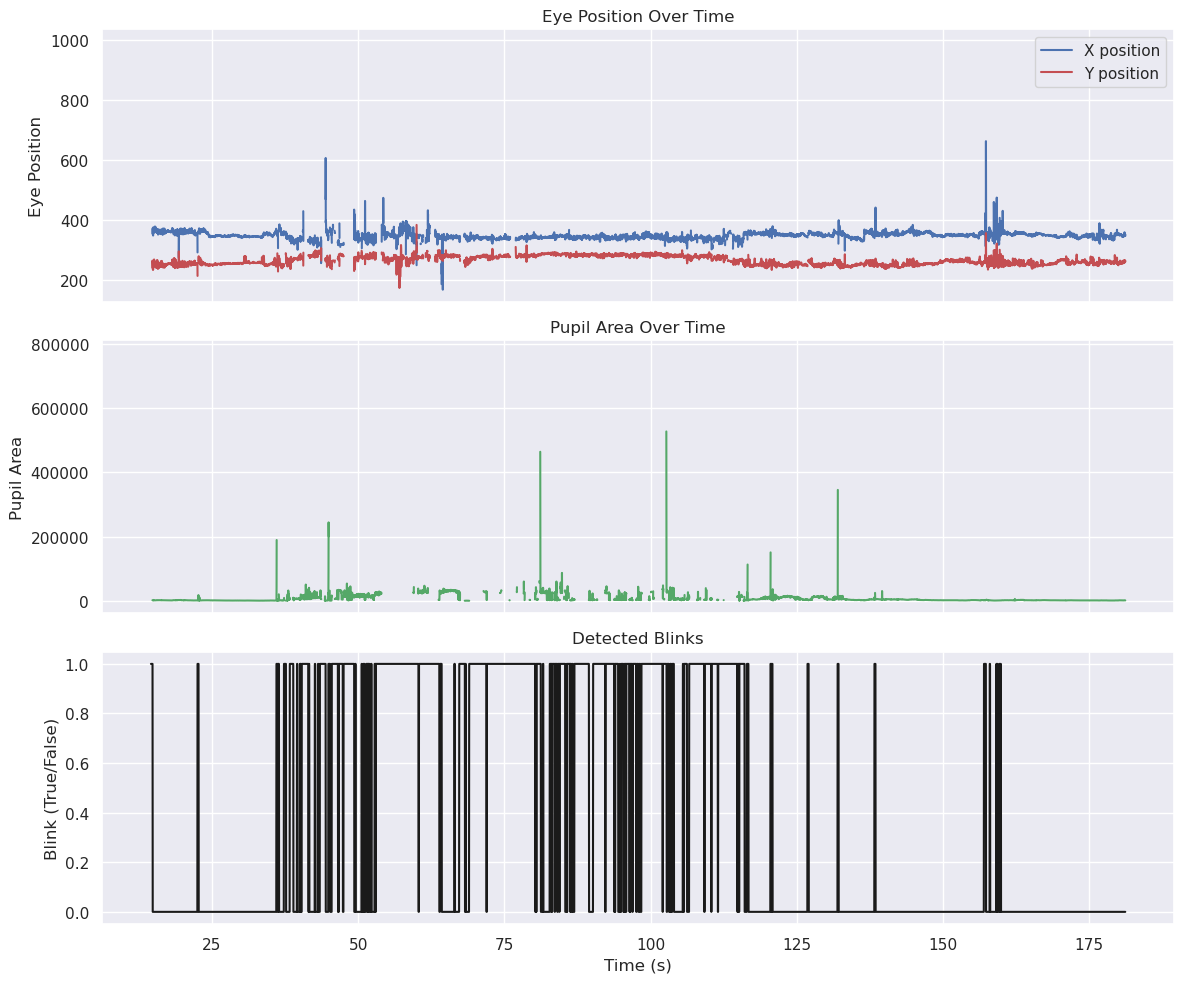

In [6]:
# Extract eye tracking data
eye_tracking = nwb_image.acquisition['EyeTracking'].eye_tracking
pupil_tracking = nwb_image.acquisition['EyeTracking'].pupil_tracking
blink_data = nwb_image.acquisition['EyeTracking'].likely_blink

# Get a sample of data (first 10,000 points)
sample_size = 10000
timestamps = eye_tracking.timestamps[:sample_size]  # This loads into memory
eye_pos = eye_tracking.data[:sample_size, :]
pupil_pos = pupil_tracking.data[:sample_size, :]
blinks = blink_data.data[:sample_size]
pupil_area = pupil_tracking.area[:sample_size]

# Create the figure for eye tracking visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot eye position (x, y)
axes[0].plot(timestamps, eye_pos[:, 0], 'b-', label='X position')
axes[0].plot(timestamps, eye_pos[:, 1], 'r-', label='Y position')
axes[0].set_ylabel('Eye Position')
axes[0].legend()
axes[0].set_title('Eye Position Over Time')

# Plot pupil area
axes[1].plot(timestamps, pupil_area, 'g-')
axes[1].set_ylabel('Pupil Area')
axes[1].set_title('Pupil Area Over Time')

# Plot blinks (as boolean)
axes[2].plot(timestamps, blinks, 'k-')
axes[2].set_ylabel('Blink (True/False)')
axes[2].set_xlabel('Time (s)')
axes[2].set_title('Detected Blinks')

plt.tight_layout()
plt.show()

### Analyzing Running Speed Data

Let's also look at the running wheel data to understand the mouse's behavior during the experiment.

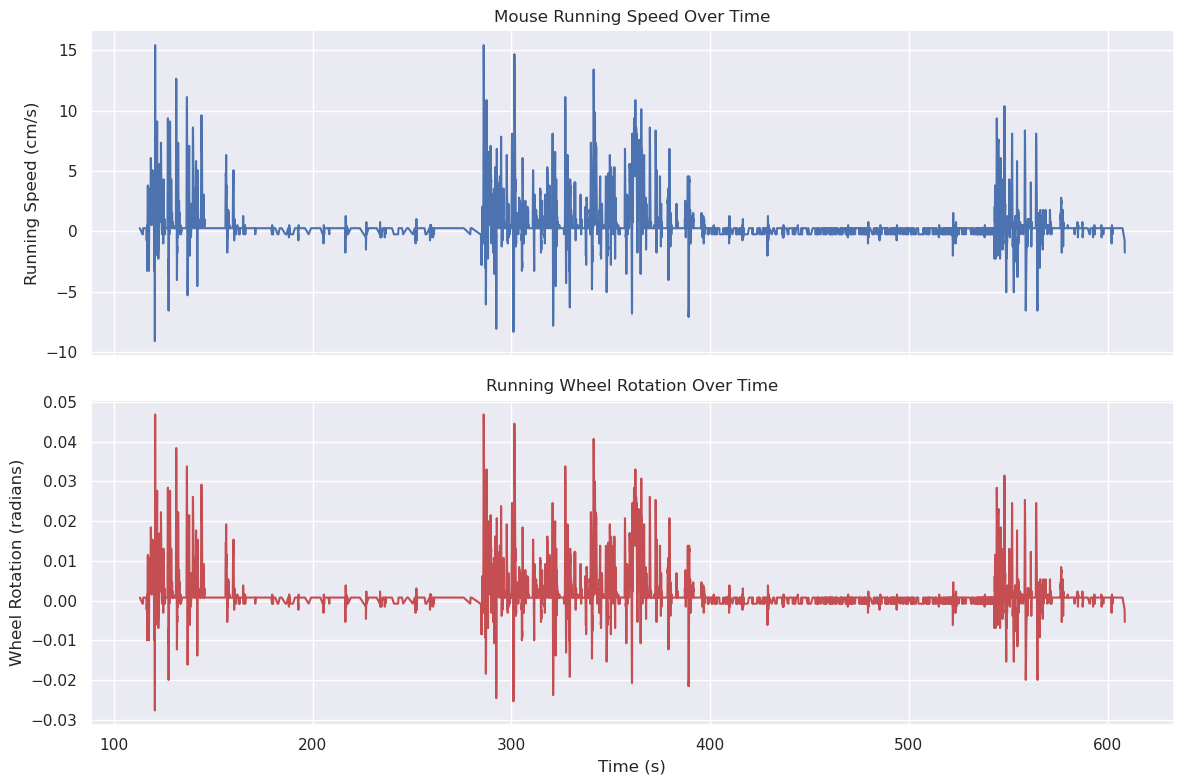

In [7]:
# Extract running data
running_module = nwb_image.processing['running']
running_speed = running_module.data_interfaces['running_speed']
wheel_rotation = running_module.data_interfaces['running_wheel_rotation']

# Get a sample of running data
sample_size_running = min(10000, running_speed.data.shape[0])
running_timestamps = running_speed.timestamps[:sample_size_running]
speed_data = running_speed.data[:sample_size_running]
rotation_data = wheel_rotation.data[:sample_size_running]

# Plot running data
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot running speed
axes[0].plot(running_timestamps, speed_data, 'b-')
axes[0].set_ylabel('Running Speed (cm/s)')
axes[0].set_title('Mouse Running Speed Over Time')

# Plot wheel rotation
axes[1].plot(running_timestamps, rotation_data, 'r-')
axes[1].set_ylabel('Wheel Rotation (radians)')
axes[1].set_xlabel('Time (s)')
axes[1].set_title('Running Wheel Rotation Over Time')

plt.tight_layout()
plt.show()

## Loading and Exploring Neural Data (LFP)

Now, let's look at the neural data from one of the probe recordings to understand the electrophysiological signals recorded during the experiment.

In [8]:
# Let's load an ecephys (LFP) file from the same subject
ecephys_file_url = "https://api.dandiarchive.org/api/assets/ba8760f9-91fe-4c1c-97e6-590bed6a783b/download/"
print(f"Loading ecephys file from URL: {ecephys_file_url}")

# Load the file
remote_file_ecephys = remfile.File(ecephys_file_url)
h5_file_ecephys = h5py.File(remote_file_ecephys)
io_ecephys = pynwb.NWBHDF5IO(file=h5_file_ecephys)
nwb_ecephys = io_ecephys.read()

# Display basic info about the ecephys file
print(f"\nFile identifier: {nwb_ecephys.identifier}")
print(f"Session description: {nwb_ecephys.session_description}")

Loading ecephys file from URL: https://api.dandiarchive.org/api/assets/ba8760f9-91fe-4c1c-97e6-590bed6a783b/download/


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."



File identifier: 0
Session description: LFP data and associated info for one probe


### Exploring LFP Data and Electrode Information

In [9]:
# Get information about the electrode groups
print("Electrode Group Information:")
for group_name, group in nwb_ecephys.electrode_groups.items():
    print(f"Group: {group_name}")
    print(f"  Description: {group.description}")
    print(f"  Location: {group.location}")
    print(f"  Sampling Rate: {group.lfp_sampling_rate} Hz")

# Let's look at the electrode table to understand the probe layout
electrode_df = nwb_ecephys.electrodes.to_dataframe()
print(f"\nTotal number of electrodes: {len(electrode_df)}")
print("\nElectrode sample (first 5 rows):")
print(electrode_df.head()[['group_name', 'location', 'probe_vertical_position', 'probe_horizontal_position']])

Electrode Group Information:
Group: probeA
  Description: Ecephys Electrode Group
  Location: See electrode locations
  Sampling Rate: 625.0 Hz

Total number of electrodes: 95

Electrode sample (first 5 rows):
   group_name location  probe_vertical_position  probe_horizontal_position
id                                                                        
2      probeA       PF                       40                         59
6      probeA       TH                       80                         59
10     probeA       TH                      120                         59
14     probeA       TH                      160                         59
18     probeA       LP                      200                         59


### Visualizing LFP Data from Selected Channels

LFP Data Shape: (10117092, 95)
Sampling Rate: 625.0 Hz
Number of Channels: 95
Time Duration: 16187.35 seconds


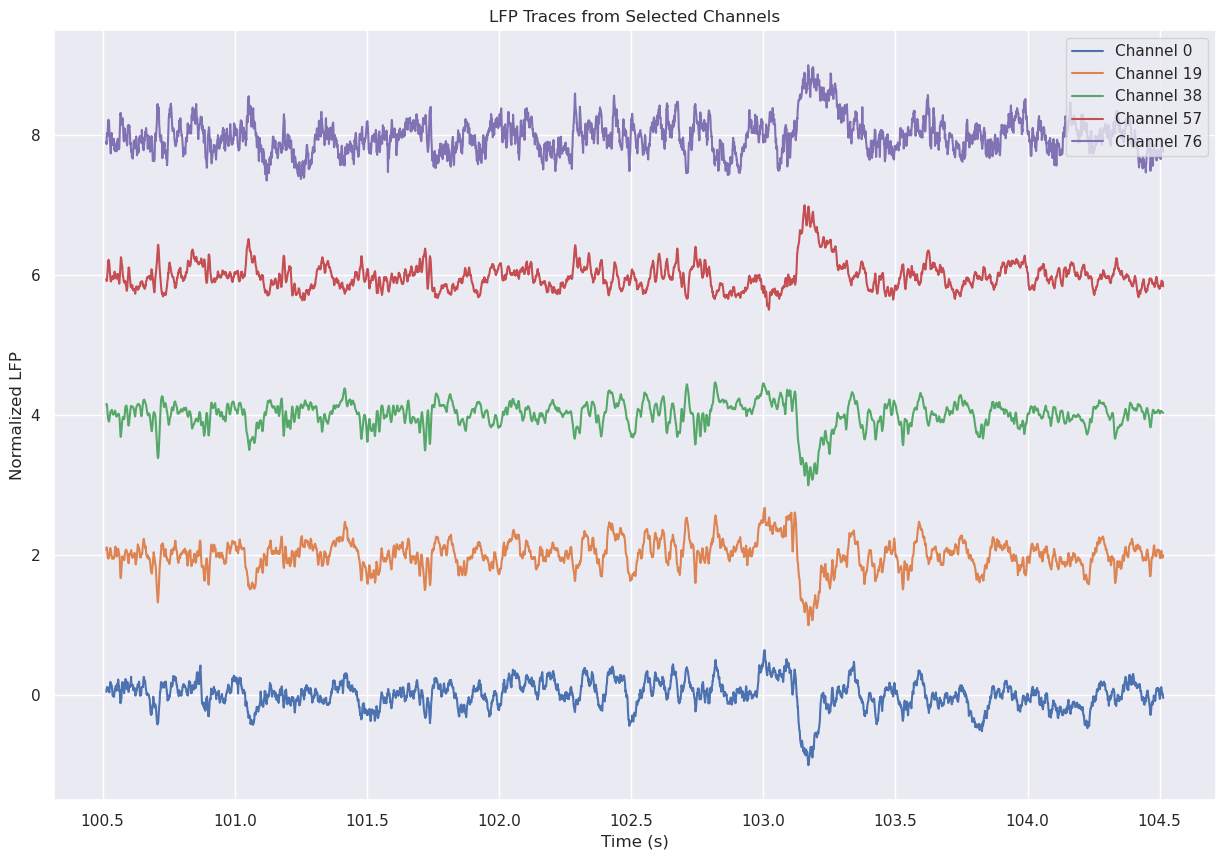

In [10]:
# Access the LFP data
lfp = nwb_ecephys.acquisition['probe_0_lfp'].electrical_series['probe_0_lfp_data']

# Get information about the LFP data
print(f"LFP Data Shape: {lfp.data.shape}")
print(f"Sampling Rate: {nwb_ecephys.electrode_groups['probeA'].lfp_sampling_rate} Hz")
print(f"Number of Channels: {lfp.data.shape[1]}")
print(f"Time Duration: {lfp.data.shape[0] / nwb_ecephys.electrode_groups['probeA'].lfp_sampling_rate:.2f} seconds")

# Let's plot LFP traces from a few channels for a short time segment
# We'll select a subset of channels and time points to visualize
num_channels_to_plot = 5
channel_indices = np.arange(0, lfp.data.shape[1], lfp.data.shape[1]//num_channels_to_plot)[:num_channels_to_plot]
start_time = 100000  # Starting index for the time segment
duration_indices = 5000  # Number of time points to plot

# Get the data subset
lfp_times = lfp.timestamps[start_time:start_time+duration_indices]
lfp_subset = lfp.data[start_time:start_time+duration_indices, channel_indices]

# Plot the LFP traces
plt.figure(figsize=(15, 10))
offset = 0
for i, channel_idx in enumerate(channel_indices):
    # Normalize the signal for better visualization
    signal_to_plot = lfp_subset[:, i]
    signal_norm = signal_to_plot / np.max(np.abs(signal_to_plot))
    plt.plot(lfp_times, signal_norm + offset, label=f'Channel {channel_idx}')
    offset += 2  # Add offset for better visualization

plt.xlabel('Time (s)')
plt.ylabel('Normalized LFP')
plt.title('LFP Traces from Selected Channels')
plt.legend()
plt.grid(True)
plt.show()

### Computing and Visualizing Power Spectrum for Selected Channels

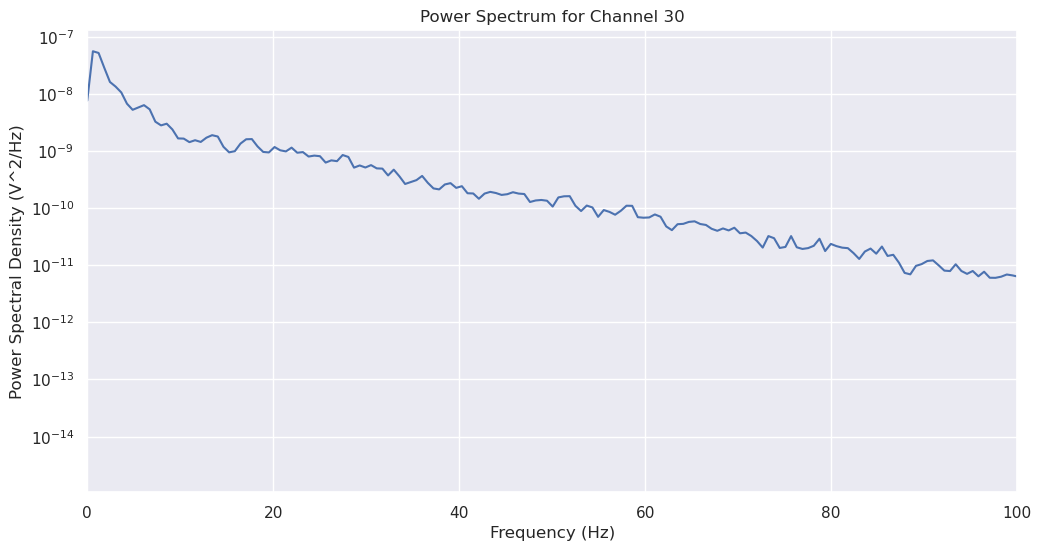

In [11]:
# Compute power spectrum for selected channels
sampling_rate = nwb_ecephys.electrode_groups['probeA'].lfp_sampling_rate
channel_index = 30  # Choose one channel for spectral analysis

# Get a longer segment of data for one channel
data_length = 20000  # 20000 points for better frequency resolution
lfp_for_spectrum = lfp.data[start_time:start_time+data_length, channel_index]

# Compute power spectrum using Welch's method
frequencies, power = signal.welch(lfp_for_spectrum, fs=sampling_rate, nperseg=1024)

# Plot the power spectrum
plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.title(f'Power Spectrum for Channel {channel_index}')
plt.xlim([0, 100])  # Focus on frequencies up to 100 Hz
plt.grid(True)
plt.show()

## Analyzing Neural Activity in Relation to Visual Stimuli

Now let's look at how neural activity relates to the visual stimuli by aligning LFP data with stimulus presentation times.

Selected stimulus: SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
Number of presentations: 57600

Sample stimulus presentations:
    start_time  stop_time                     stimulus_name  orientation
id                                                                      
0    113.08087  113.09755  SAC_Wd15_Vel2_Bndry1_Cntst0_loop          0.0
1    113.08087  113.09755  SAC_Wd15_Vel2_Bndry1_Cntst0_loop          0.0
2    113.09755  113.11446  SAC_Wd15_Vel2_Bndry1_Cntst0_loop          0.0
3    113.09755  113.11446  SAC_Wd15_Vel2_Bndry1_Cntst0_loop          0.0
4    113.11446  113.13090  SAC_Wd15_Vel2_Bndry1_Cntst0_loop          0.0

Selected presentations for analysis:
 start_time  stop_time  orientation
  553.58300  553.59968          0.0
  553.59968  553.61637          0.0
  553.59968  553.61637          0.0
  553.61637  553.63305          0.0
  553.61637  553.63305          0.0

Time window: 552.58s to 554.63s


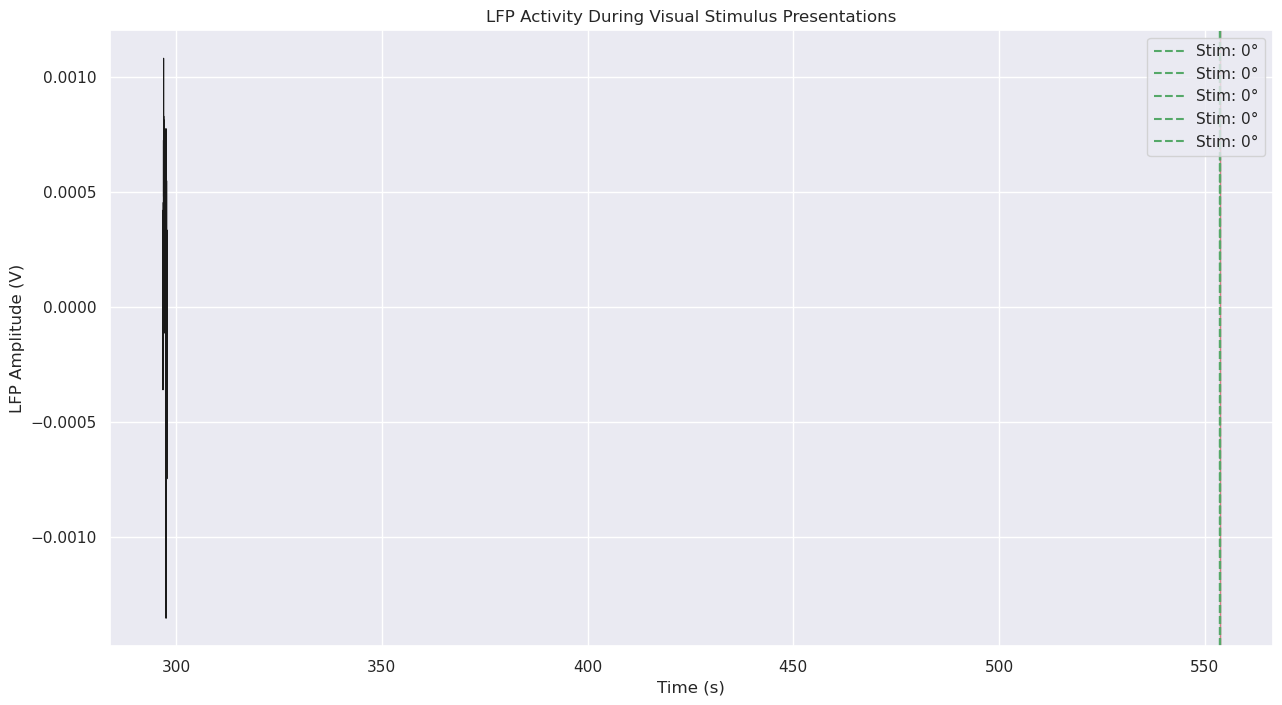

In [12]:
# Let's select one specific stimulus type from the image file
stimulus_key = 'SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations'
stimulus_presentations = nwb_image.intervals[stimulus_key].to_dataframe()
print(f"Selected stimulus: {stimulus_key}")
print(f"Number of presentations: {len(stimulus_presentations)}")
print("\nSample stimulus presentations:")
print(stimulus_presentations[['start_time', 'stop_time', 'stimulus_name', 'orientation']].head())

# Find stimulus presentations in a suitable time range for our LFP data
# We want to align a stimulus presentation with our LFP data
start_idx = np.random.randint(0, len(stimulus_presentations) - 10)
selected_presentations = stimulus_presentations.iloc[start_idx:start_idx+5]
print("\nSelected presentations for analysis:")
print(selected_presentations[['start_time', 'stop_time', 'orientation']].to_string(index=False))

# Get a time window covering these presentations
start_time_sec = selected_presentations['start_time'].min() - 1  # 1 second before
end_time_sec = selected_presentations['stop_time'].max() + 1    # 1 second after
print(f"\nTime window: {start_time_sec:.2f}s to {end_time_sec:.2f}s")

# Convert to indices in the LFP data
start_idx_lfp = int(start_time_sec * sampling_rate)
end_idx_lfp = int(end_time_sec * sampling_rate)

# Make sure indices are within valid range
if start_idx_lfp < 0:
    start_idx_lfp = 0
if end_idx_lfp >= lfp.data.shape[0]:
    end_idx_lfp = lfp.data.shape[0] - 1

# Extract the LFP data for this time window
lfp_time_window = lfp.timestamps[start_idx_lfp:end_idx_lfp]
lfp_data_window = lfp.data[start_idx_lfp:end_idx_lfp, channel_index]

# Plot the LFP data with stimulus onset times marked
plt.figure(figsize=(15, 8))
plt.plot(lfp_time_window, lfp_data_window, 'k-', linewidth=0.8)

# Mark stimulus presentation periods
for _, stim in selected_presentations.iterrows():
    plt.axvspan(stim['start_time'], stim['stop_time'], color='r', alpha=0.2)
    plt.axvline(stim['start_time'], color='g', linestyle='--', lw=1.5, 
                label=f"Stim: {int(stim['orientation'])}°" if 'orientation' in stim else "Stim")
    
plt.xlabel('Time (s)')
plt.ylabel('LFP Amplitude (V)')
plt.title('LFP Activity During Visual Stimulus Presentations')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Computing Time-Frequency Analysis for Stimulus Response

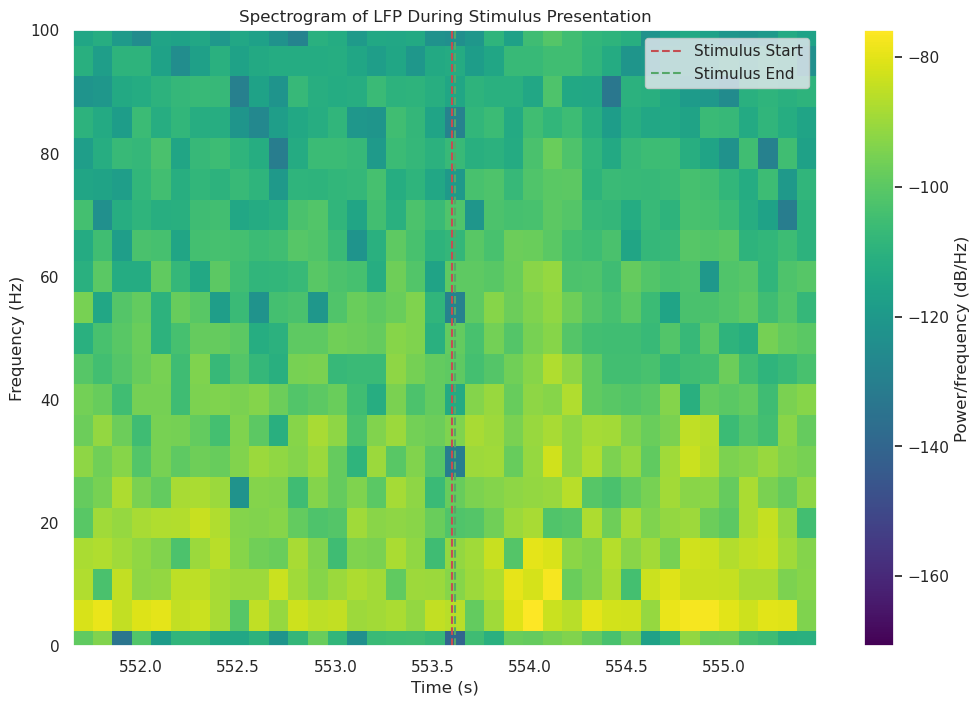

In [13]:
# Let's perform a time-frequency analysis to see how different frequency bands respond to stimuli
# We'll use a spectrogram to visualize frequency content over time

# Choose a time window around one stimulus presentation
stim_idx = 2  # Choose one of our selected presentations
stim_start = selected_presentations.iloc[stim_idx]['start_time']
stim_end = selected_presentations.iloc[stim_idx]['stop_time']

# Get data from 2 seconds before to 2 seconds after the stimulus
pre_stim = 2  # seconds before stimulus
post_stim = 2  # seconds after stimulus
spec_start_time = stim_start - pre_stim
spec_end_time = stim_end + post_stim

# Convert to indices
spec_start_idx = max(0, int(spec_start_time * sampling_rate))
spec_end_idx = min(lfp.data.shape[0], int(spec_end_time * sampling_rate))

# Get the data for this time window
spec_times = lfp.timestamps[spec_start_idx:spec_end_idx]
spec_data = lfp.data[spec_start_idx:spec_end_idx, channel_index]

# Compute spectrogram
nperseg = int(sampling_rate * 0.2)  # 200ms segments
noverlap = nperseg // 2
frequencies, times, Sxx = signal.spectrogram(spec_data, fs=sampling_rate, 
                                           nperseg=nperseg, noverlap=noverlap)

# Adjust times to match the stimulus window
times = times + spec_start_time

# Plot spectrogram
plt.figure(figsize=(12, 8))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto', cmap='viridis')
plt.colorbar(label='Power/frequency (dB/Hz)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram of LFP During Stimulus Presentation')
plt.ylim([0, 100])  # Limit to 0-100 Hz

# Mark stimulus period
plt.axvline(stim_start, color='r', linestyle='--', label='Stimulus Start')
plt.axvline(stim_end, color='g', linestyle='--', label='Stimulus End')
plt.legend()
plt.show()

## Correlating Eye Tracking with Neural Activity and Stimulus Presentation

Let's explore how eye movements correlate with neural activity and stimulus presentations.

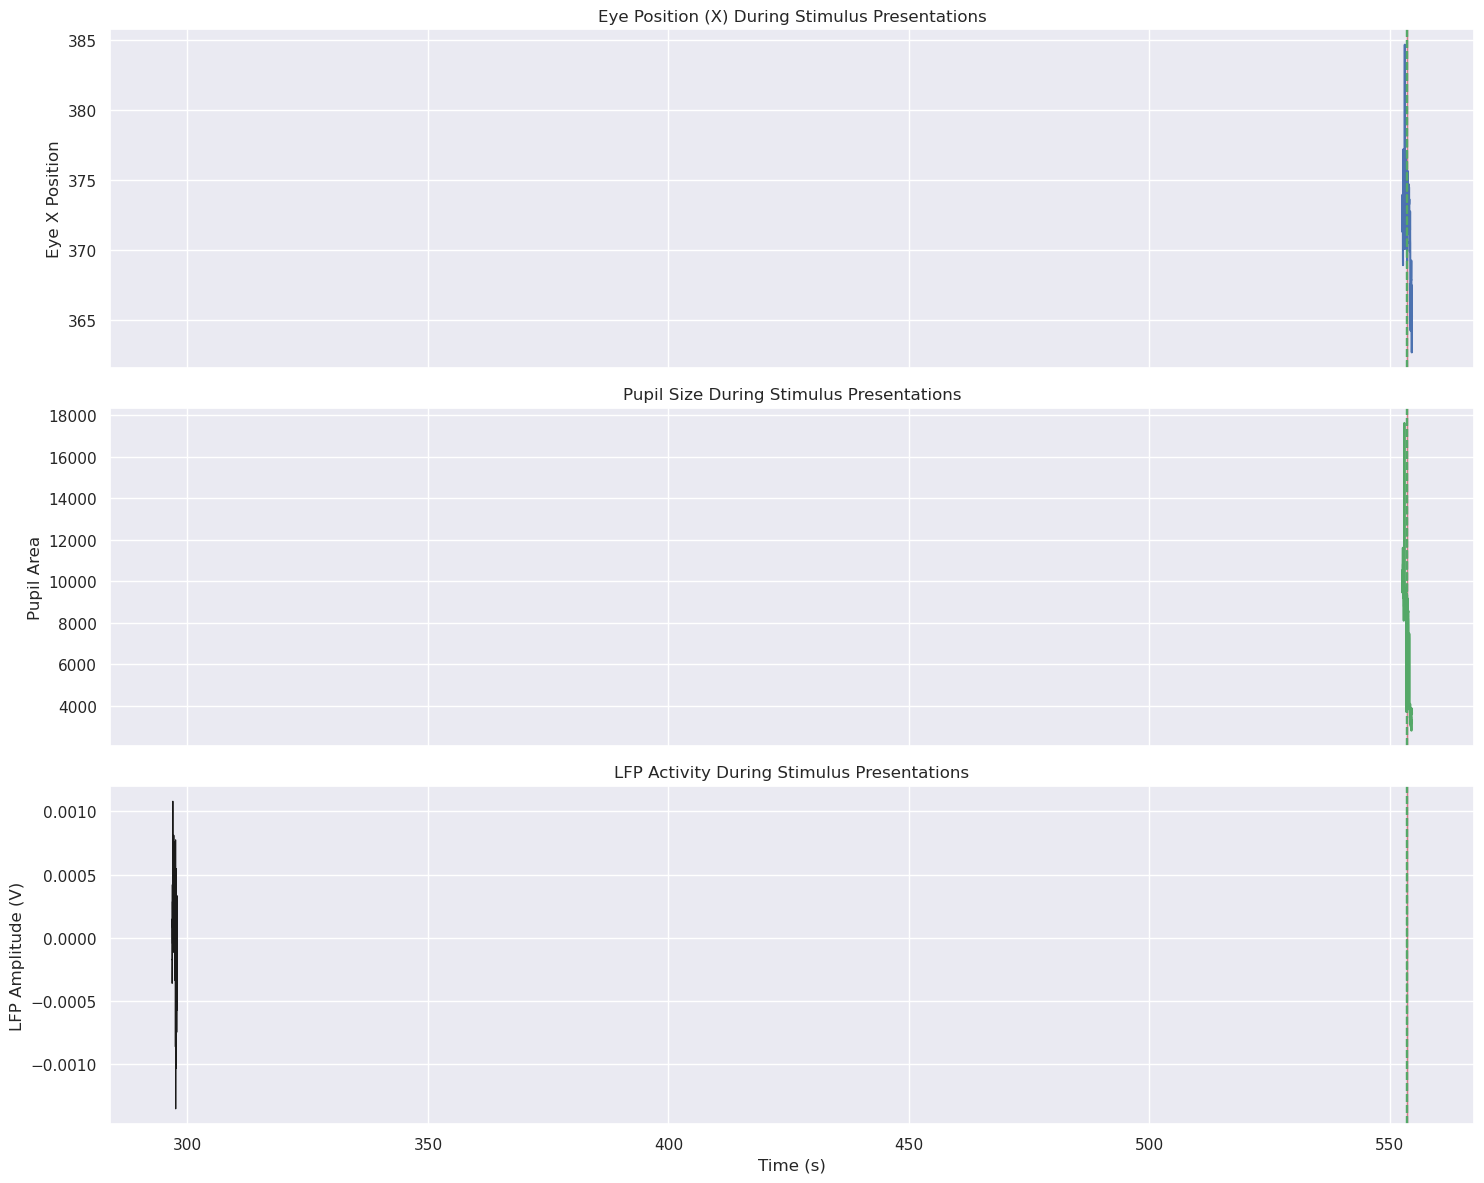

In [14]:
# First, we need to align eye tracking data with the stimulus presentations and LFP data
# Let's use the same time window as our stimulus presentations

# Extract eye tracking data for our time window
# Convert timestamps to numpy array first since Dataset doesn't support direct comparison
eye_timestamps_array = eye_tracking.timestamps[:]
eye_tracking_indices = np.where((eye_timestamps_array >= start_time_sec) & 
                              (eye_timestamps_array <= end_time_sec))[0]
eye_times = eye_timestamps_array[eye_tracking_indices]
eye_x = eye_tracking.data[eye_tracking_indices, 0]
eye_y = eye_tracking.data[eye_tracking_indices, 1]
pupil_size = pupil_tracking.area[eye_tracking_indices]

# Create a multi-panel figure
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Plot eye position (X coordinate) and pupil size
axes[0].plot(eye_times, eye_x, 'b-', label='Eye X Position')
axes[0].set_ylabel('Eye X Position')
axes[0].set_title('Eye Position (X) During Stimulus Presentations')
axes[0].grid(True)

# Plot pupil size
axes[1].plot(eye_times, pupil_size, 'g-', label='Pupil Size')
axes[1].set_ylabel('Pupil Area')
axes[1].set_title('Pupil Size During Stimulus Presentations')
axes[1].grid(True)

# Plot LFP data
axes[2].plot(lfp_time_window, lfp_data_window, 'k-', linewidth=0.8)
axes[2].set_ylabel('LFP Amplitude (V)')
axes[2].set_xlabel('Time (s)')
axes[2].set_title('LFP Activity During Stimulus Presentations')
axes[2].grid(True)

# Mark stimulus presentation periods on all subplots
for ax in axes:
    for _, stim in selected_presentations.iterrows():
        ax.axvspan(stim['start_time'], stim['stop_time'], color='r', alpha=0.2)
        ax.axvline(stim['start_time'], color='g', linestyle='--', lw=1.5)

plt.tight_layout()
plt.show()

## Analyzing Relationship Between Running Speed and Neural Activity

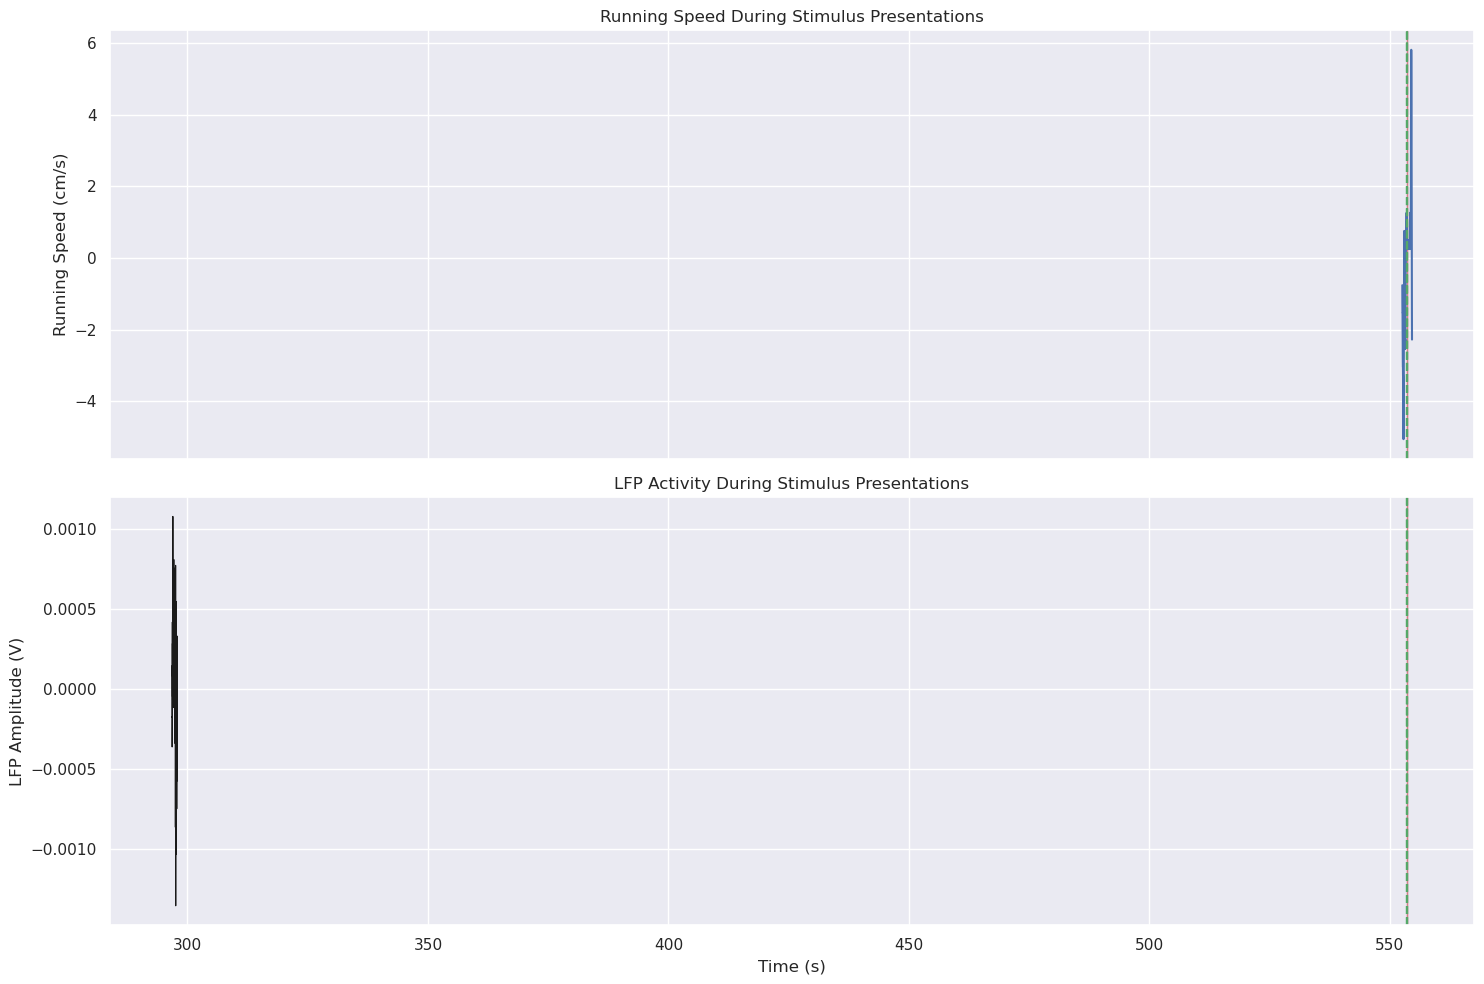

In [15]:
# Extract running speed data for the same time window
# Convert timestamps to numpy array first
running_timestamps_array = running_speed.timestamps[:]
running_indices = np.where((running_timestamps_array >= start_time_sec) & 
                           (running_timestamps_array <= end_time_sec))[0]
run_times = running_timestamps_array[running_indices]
run_speed = running_speed.data[running_indices]

# Create a multi-panel figure
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot running speed
axes[0].plot(run_times, run_speed, 'b-', label='Running Speed')
axes[0].set_ylabel('Running Speed (cm/s)')
axes[0].set_title('Running Speed During Stimulus Presentations')
axes[0].grid(True)

# Plot LFP data
axes[1].plot(lfp_time_window, lfp_data_window, 'k-', linewidth=0.8)
axes[1].set_ylabel('LFP Amplitude (V)')
axes[1].set_xlabel('Time (s)')
axes[1].set_title('LFP Activity During Stimulus Presentations')
axes[1].grid(True)

# Mark stimulus presentation periods on all subplots
for ax in axes:
    for _, stim in selected_presentations.iterrows():
        ax.axvspan(stim['start_time'], stim['stop_time'], color='r', alpha=0.2)
        ax.axvline(stim['start_time'], color='g', linestyle='--', lw=1.5)

plt.tight_layout()
plt.show()

## Summary of Findings

In this notebook, we have explored Dandiset 000690 from the Allen Institute Openscope Vision2Hippocampus project. Here's a summary of what we've learned:

1. **Dataset Structure**: The dataset contains multiple NWB files for different subjects, including main session files, image files with stimulus data, and probe-specific ecephys files.

2. **Visual Stimuli**: The dataset includes various visual stimuli presented to mice, including moving bars with different properties (widths, speeds, contrasts) and natural movies.

3. **Neural Recordings**: The dataset contains LFP recordings from Neuropixel probes, allowing us to examine neural activity in different brain regions during visual stimulus presentation.

4. **Behavioral Data**: The dataset includes eye tracking and running wheel data, providing insight into the mouse's behavior during the experiment.

5. **Neural Responses to Visual Stimuli**: We observed changes in LFP activity that appeared to correlate with visual stimulus presentations, suggesting neural processing of visual information.

6. **Time-Frequency Analysis**: Spectrograms revealed frequency-specific responses to visual stimuli, with potential power modulations in different frequency bands.

7. **Multimodal Data Integration**: We were able to align neural activity with behavioral measures like eye movements and running speed, showing the potential for comprehensive analysis of neural processing in the context of behavior.

## Future Directions

This notebook provides just a starting point for analyzing this rich dataset. Future analyses could include:

1. Systematic comparison of neural responses across different brain regions (thalamus, visual cortex, hippocampus)
2. Detailed analysis of how neural responses vary with different stimulus properties
3. Investigation of how behavioral state (running vs. stationary) affects neural processing of visual information
4. Analysis of connectivity and information flow between brain regions during visual processing
5. Comparison of responses to artificial stimuli vs. natural movies
6. Population-level analyses of neural coding strategies across the visual processing hierarchy